# MNIST

The following code fetches the MNIST dataset from Scikit-learn's popular datasets helper function *fetch_openml()*

In [76]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded from Scikit-learn have a similar dictionary structure. 

1. A *DESCR* key describing the dataset
2. A *data* key containing an array with one row per instance and one column per feature
3. A *target* key containing an array with the labels

In [77]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [78]:
y.shape

(70000,)

There are 70000 images and each image has 784 features. This is because each image is 28x28 pixels, and each feature represents one pixel's intensity from 0 (white) to 255 (black). Taking a peek at one digit from the dataset. To grab an instance's feature vector, reshape it to a 28x28 array and display using Matplotlib's *imshow()* function

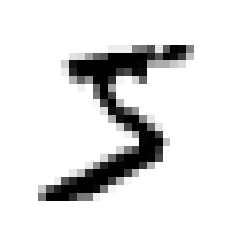

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [80]:
y[0]

'5'

Most ML algos accept numbers and the output above is a string, so converting it to int

In [81]:
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is already split into a train and test set with the first 60000 rows being the train set and the last 10000 rows being the test set

In [82]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Simplifying the problem to a binary classification problem of detecting if an instance is 5 or not 5

In [83]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

A good model to start with is the *Stochastic Gradient Descent* classifier, using Scikit-learn's **SGDClassifier** class.

In [84]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [85]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation

In some cases, it might be helpful to implement our own Cross-Validation function to get a proper stratified split om the data using **StratifiedKFold**

In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Splitting the training set into 3 folds using the **cross_val_score()** function

In [87]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy on all folds seems good but is deceiving. Testing another classifier that classifies every single image in the "not 5" class

In [88]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [89]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Above 90% accuracy. Again, seems good but that is only happening because only 10% of the dataset contains 5s. So even if the classifier predicted all instances as not 5 it would have at least a 90% accuracy.

This shows that generally accuracy is not a preferred metric, especially when the dataset is *skewed*.

### Confusion Matrix

A confusion matrix is one of the metrics used to evaluate classifiers. The general idea is to count the number of times class A was classified as class B. 

To compute the confusion matrix, we first need a set of predictions that can be compared to the actual targets. We use the **cross_val_predict()** function to get the predictions on K folds instead of the scores.

In [90]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [91]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an *actual class* while each column represents a *predicted class*. The first row of this matrix considers non-5 images (the *negative class*). 53892 of them were correctly predicted as not 5 (*true negatives*), while the remaining 687 were wrongly classified as 5s (*false positives*). The second row considers the 5 images (*positive class*). 1891 of them were wrongly classified as non-5s (*false negatives*) while 3530 of them were correctly classified as 5s (*true positives*). 

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have non-zero values only on its main diagonal.

In [92]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix is a good metric but in case we need some more concise information, we can use the precision and recall scores.

Precision is a ratio of the number of true positives out of all the positive predictions made. Precision = TP/(TP+FP).

Recall/Sensitivity/True positive rate (TPR) is measure of how many positives were captured out of all the positives. Recall = TP/(TP+FN)

### Precision and Recall

In [93]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [94]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Our model doesn't look as good now as it did with the accuracy metric. It only has a precision of 83.71% and a recall of 65.12%. 

It is often convenient to combine the precision and recall score into a single metric called the F1 score. The F1 score is the harmonic mean of the precision and recall scores. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values as a result of which the classifier only gets a high F1 score if both recall and precision are high.

In [95]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score usually favors classifiers that have similar precision and recall scores which is not always good. Sometimes, aaccording to our problem we may need a high precision and low recall or vice versa. 

Increasing precision reduces recall and vice versa. This is called *precision/recall trade-off*.

### Precision/Recall Trade-off

To understand this trade-off, we must understand how a classifier makes its decisions. The **SGDClassifier** makes its classification decisions based on a score based on a *decision function*. If the score is greater than a *threshold*, it assigns the instance to the positive class; otherwise to the negative class. 

Scikit-learn doesn't allow us to set the threshold directly but it does give access to the decision scores that it uses to make predictions. Instead of calling the classifier's **predict()** method, we can call its **decision_function()** method, which returns a score for each instance, and then use any threshold we want to make predictions based on those scores.

In [96]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [97]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The **SGDClassifier** uses a thresold equal to 0 so the previous code returns the same result as the **predict()** method, True.

In [98]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The classifier misses the 5 label when the threshold is set to 8000

The decision of what threshold to use is made by first using the **cross_val_predict()** method to get the decision scores by specifying the method hyperparameter to *decision_function*

In [99]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

We use these scores to plot the **precision_recall_curve()** to compute precision and recall for all possible thresholds.

In [100]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, we use matplotlib to plot this curve

In [101]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

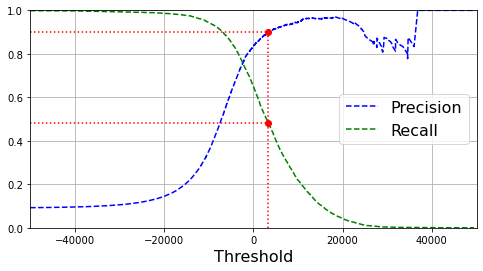

In [102]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
#save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

The precision curve is bumpy towards the end because the precision may sometimes fluctuate as we increase the threshold while the recall always decreases

Suppose we want a 90% precision for our problem, we can do that using the code below

In [103]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [104]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [105]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [106]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve but instead of plotting precision versus recall, the ROC curve plots the *true positive rate* (recall) against the *false positive rate*. It is equal to 1 - the *true negative rate*. The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity (recall)* versus 1 - *specificity*.

In [107]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

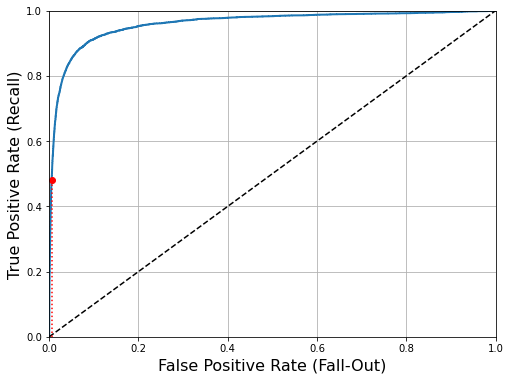

In [108]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")               
#save_fig("roc_curve_plot")                                    
plt.show()

There is a trade-off again. The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier, a good classifier stays as far away from that line as possible (towards the top-left) corner.

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, while a completely random one will have 0.5.

In [109]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As to what to choose as a metric between the PR curve and the ROC curve, as a rule of thumb, whenever the positive class is rare or when we care more about the false positives than false negatives, we use the PR curve. Else, we use the ROC curve.

We now test a **RandomForestClassifier** instead of the SGDClassifier

In [110]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [111]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

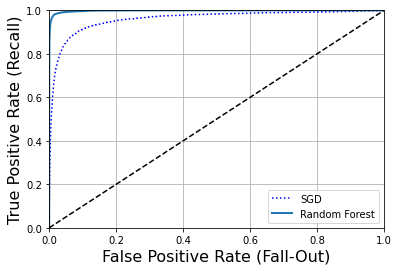

In [112]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [113]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The **RandomForestClassifier** clearly outperforms the **SGDClassifier** in all metrics

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, *multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms (such as SGD, RF, NB) are capable of handling multiple classes natively. While others (such as Logistic Regression and SVM) are strictly binary classifiers.

One way to create a system for multiclass classification is to train 10 binary classifiers one for each digit, then to classify the image, select the class with the highest score. This is called *one-versus-rest* (OvR) strategy (also called *one-versus-all*).

Another strategy is to train a binary classifier for every pair of digits. This is called *one-versus-one* (OvO) strategy. 

Scikit-learn detects when we try to use a binary classification algoritm for a multiclass classification task, and it automatically runs OvR or OvO depending on the algorithm. 

In [114]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) 
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on all classes (0 to 9), instead of 5 versus rest. Then it makes a correct prediction. It uses the OvO strategy under the hood to compute this. 

If we call the **decision_function()** method, we see it computes 10 scores instead of 1

In [115]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [116]:
np.argmax(some_digit_scores)

5

In [117]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If we want to force Scikit-Learn to use OvO or OvR, we can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes. Simply create an instance and pass a classifier to its constructor.

In [118]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [119]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [120]:
len(ovr_clf.estimators_)

10

In [121]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [122]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [123]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [124]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

We first generate the confusion matrix

In [125]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Having the numbers is not very informative, it is better to get a pictorial representation

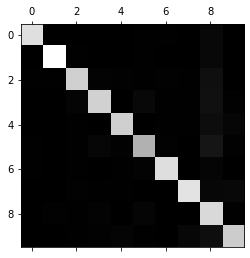

In [126]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Since we do not want a skewed confusion matrix due to skewness in the data, we divide the confusion matrix by the number of instances of each class to get a normalized confusion matrix

In [127]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

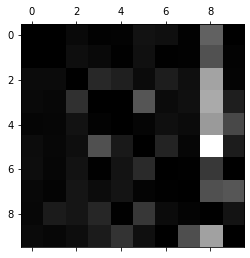

In [128]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

This matrix tells us that numbers often get mis-predicted as 8s looking at the 8 column but the true 8s are properly classified as 8s in most cases by looking at row 8. 

The confusion matrix gives us a good idea on what errors we should analyze (the 8s mentioned above, which can be resolved by adding some features by counting the number of closed loops and 3s and 5s often getting mis-predicted)

In [131]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

We plot the 3s and 5s to see why the classifier is misclassifying them so much and realize that a lot of the instances have poor handwriting causing this. The line connecting the upper line of 5 to the lower curve seems like a good distinguishing feature though.

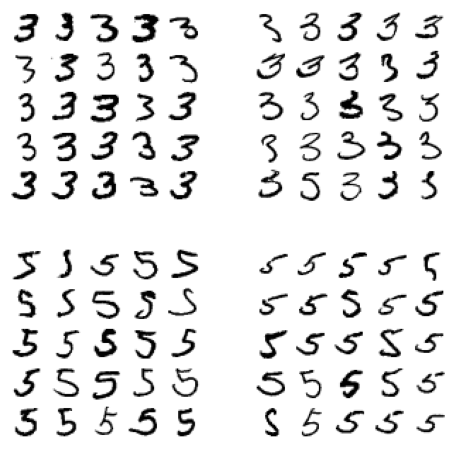

In [132]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

Until now each instance has only been assigned to one class. However, we may come across problems where we need to output multiple classes for each instance like in a face recognition system needed to classify a set of images as three different people for example ([1, 0, 1]). Such a classification problem, that outputs multiple binary tags is called *multilabel classification*.

We test an example of classifying an instance into two labels. One is if a number is larger than 7 and second if a number is odd.

In [133]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [134]:
knn_clf.predict([some_digit])

array([[False,  True]])

One way to evaluate multilabel classifiers is to compute the individual F1 score for each label then compute the average of the F1 scores for all labels as shown below.

In [135]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important. However, if we want to evaluate skewed data, we change the hyperparameter average to *support* instead of macro.

# Multioutput Classification

*Multioutput-multiclass classification* or simply *Multioutput classification* is a generalization of multilabel classification where each label can have multiple classes instead of binary classes.

To illustrate this, we create a problem by adding noise to the data and trying to recover the original image. Notice that the output is multilabel (one label per pixel) and multiclass (pixel intensity ranges from 0 to 255).

In [136]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

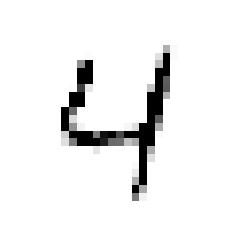

In [140]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4]])
plot_digits(clean_digit)

We try to build a classifier here with over 97% accuracy on the test set by fine tuning the hyperparameters using GridSearchCV

In [141]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"weights":["uniform", "distance"], "n_neighbors":[5, 10, 50, 100]}
]

knn_clf_new = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf_new, param_grid, cv=3, scoring="accuracy", return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 10, 50, 100],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [142]:
grid_search.best_estimator_

KNeighborsClassifier(weights='distance')

In [143]:
grid_search.best_score_

0.9686

In [145]:
knn_clf_new = KNeighborsClassifier(weights="distance", n_neighbors=5)
knn_clf_new.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [146]:
y_test_pred = knn_clf_new.predict(X_test)

In [147]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.9691